(techniques:concolic_execution)=
# Concolic Execution

```{admonition} TODO
Write text.
```

In [1]:
import utils
from symbolic_interpreter import *
from compositional import *

In [2]:
class ConcolicInterpreter(SymbolicInterpreter):
    def __init__(
            self, concrete_store: Store,
            predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__(predicates=predicates)
        self.concrete_store = concrete_store
        self.subst_map: Dict[z3.ExprRef, z3.ExprRef] = {
            variable.to_z3(): python_expr_to_z3_expr(self.concrete_store.env[variable])
            for variable in self.concrete_store.env}

    def constraint_satisfied(self, constraint: z3.BoolRef) -> bool:
        return is_unsat(z3.Not(subst(constraint, self.subst_map)))

    def execute_try_stmt(self, stmt: TryStmt, environment: SymbolicEnvironment) -> SET:
        tree = self.execute(stmt.block, environment)
        result = (SETNode(environment, stmt.code), [tree])

        for leaf in get_leaves(tree):
            node, _ = leaf
            exc = node.environment.abrupt_completion
            if exc is None or isinstance(exc, AbruptCompletionNoException):
                continue

            if stmt.exc_type is not None:
                caught_exc_type = getattr(sys.modules["builtins"], stmt.exc_type)
                if isinstance(exc, caught_exc_type):
                    catch_block_tree = self.execute(stmt.except_block,
                                                    node.environment.set_abrupt_completion(None))
                    result = replace_in_tree(result, leaf, catch_block_tree)
            else:
                catch_block_tree = self.execute(stmt.block, node.environment.set_abrupt_completion(None))
                result = replace_in_tree(result, leaf, catch_block_tree)

        return result

    def execute_if_stmt(self, stmt: IfStmt, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.guard, environment)

        result: SET = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if exc_node.environment.concretize(self.concrete_store) is not None:
                    result[1].append((exc_node, []))
                continue

            assert z3.is_bool(value)

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if then_env.concretize(self.concrete_store) is not None:
                subtree = self.execute_block(stmt.then_block, then_env)
                result[1].append(subtree)

            else_constraint = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if else_env.concretize(self.concrete_store) is not None:
                if stmt.else_block is not None:
                    subtree = self.execute_block(stmt.else_block, else_env)
                    result[1].append(subtree)
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

    def execute_while_stmt(self, stmt: WhileStmt, environment: SymbolicEnvironment,
                           loop_unrolling_threshold: Optional[int] = None) -> SET:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        result = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_guard_res:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if exc_node.environment.concretize(self.concrete_store) is not None:
                    result[1].append((exc_node, []))
                continue

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if then_env.concretize(self.concrete_store) is not None:
                subtree = self.execute_block(stmt.body, then_env)
                result[1].append(subtree)
                for leaf in get_leaves(subtree):
                    node, _ = leaf
                    env = node.environment
                    exc = env.abrupt_completion
                    if exc is not None:
                        if isinstance(exc, Continue):
                            env = env.set_abrupt_completion(None)
                        elif isinstance(exc, Break):
                            env = env.set_abrupt_completion(None)
                            result = replace_in_tree(
                                result, leaf, (SETNode(env, ''), []))
                            continue
                        else:
                            continue

                    while_tree = self.execute_while_stmt(stmt, env)
                    result = replace_in_tree(result, leaf, while_tree)
                    continue

            else_constraint: z3.BoolRef = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if else_env.concretize(self.concrete_store) is not None:
                if stmt.else_block is not None:
                    subtree = self.execute_block(stmt.else_block, else_env)
                    result[1].append((SETNode(else_env, 'else:'), [subtree]))
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result
    
    def execute_assert_stmt(self, stmt: Assert, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            new_env = environment.add_constraint(constraint)
            if new_env.unsatisfiable():
                continue

            if isinstance(value, Exception):
                children.append((SETNode(new_env.set_abrupt_completion(value), ''), []))
                continue

            assert isinstance(value, z3.BoolRef)
            sat_env = new_env.add_constraint(value)
            viol_env = new_env.add_constraint(z3.Not(value))

            sat_env_unsat = sat_env.concretize(self.concrete_store) is None
            viol_env_unsat = viol_env.concretize(self.concrete_store) is None

            if sat_env_unsat:
                children.append((SETNode(environment.set_abrupt_completion(AssertionError()), ''), []))
            elif viol_env_unsat:
                children.append((SETNode(environment, ''), []))
            else:
                children.append((SETNode(sat_env, ''), []))
                children.append((SETNode(viol_env.set_abrupt_completion(AssertionError()), ''), []))

        return result

    def execute_assignment(self, stmt: Assignment, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = [
            (value, constraint)
            for value, constraint in self.evaluate(stmt.expression, environment)
            if not environment.add_constraint(constraint).unsatisfiable()
        ]

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                new_env = environment.set_abrupt_completion(value)
            else:
                variable = Variable(stmt.lhs, get_type_for_z3_expr(value))
                new_env = environment.set(variable, value)

            # if len(eval_expr_result) > 1:  # <-- To collect all potentially relevant constraints
            new_env = new_env.add_constraint(constraint)

            children.append((SETNode(new_env, None), []))

        return result
    
    def evaluate(self, expr: Expression, environment: SymbolicEnvironment) -> EvalExprResult:
        t = type(expr)
        if t in self.expr_interpretations:
            result = [(value if isinstance(value, Exception) else z3.simplify(value), z3.simplify(constraint)) for
                      value, constraint in self.expr_interpretations[t](expr, environment) if
                      self.constraint_satisfied(constraint)]
            assert len(result) == 1
            return result

        assert False

In [3]:
def insertion_point(x: int, t: tuple) -> int:
    # assume Sorted(t)
    i = 0
    while i < len(t):
        if t[i] >= x:
            break

        i = i + 1

    assert PostInsertionPoint(x, t, i)
    return i

In [4]:
kv = z3.Int("k")

post_insertion_point = (
    lambda xv, tv, resultv:
    z3.And(                
        z3.IntVal(0) <= resultv,
        resultv <= z3.Length(tv),
        z3.ForAll(
            [kv],
            z3.Implies(
                z3.And(
                    kv >= z3.IntVal(0),
                    kv < resultv),
                tv[kv] < xv
            )
        ),
        z3.ForAll(
            [kv],
            z3.Implies(
                z3.And(
                    kv >= resultv,
                    kv < z3.Length(tv)),
                tv[kv] >= xv
            )
        )))

display_formula(post_insertion_point(z3.Int("x"), z3_sequence("t"), z3.Int("result")))

In [5]:
import inspect

In [6]:
insertion_point_code = "".join(inspect.getsourcelines(insertion_point)[0]).strip()
insertion_point_program = parse(insertion_point_code)
display_program(insertion_point_code)

```python
def insertion_point(x: int, t: tuple) -> int:
    # assume Sorted(t)
    i = 0
    while i < len(t):
        if t[i] >= x:
            break

        i = i + 1

    assert PostInsertionPoint(x, t, i)
    return i
```

In [7]:
x = Variable("x", INT_TYPE)
t = Variable("t", TUPLE_TYPE)

initial_store = Store({x: 1, t: (13,)})
initial_store

Store({Variable('x', Type('int')): 1, Variable('t', Type('tuple')): (13,)})

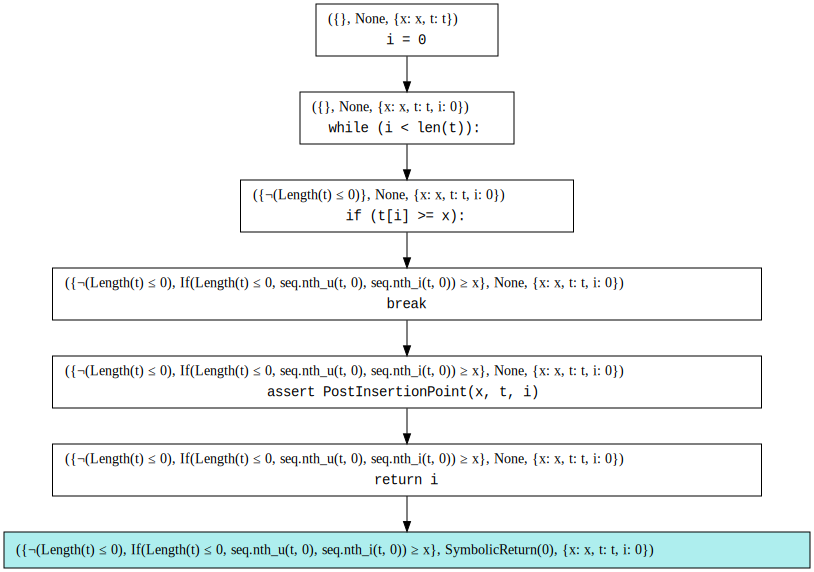

In [8]:
predicates = {
    "PostInsertionPoint": ((z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.IntSort()), z3.BoolSort(), post_insertion_point),
    "len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)
}

interpreter = ConcolicInterpreter(
    concrete_store=initial_store,
    predicates=predicates
)

insertion_point_set = interpreter.execute_function_body("insertion_point", insertion_point_program)
display_set(insertion_point_set)

In [9]:
final_constraint = z3_and(*get_leaves(insertion_point_set)[0][0].environment.path_constraints)
final_constraint

And(Not(Length(t) <= 0),
    If(Length(t) <= 0, seq.nth_u(t, 0), seq.nth_i(t, 0)) >=
    x)

In [10]:
s = z3.Solver()
s.add(z3.Not(final_constraint))
assert s.check() == z3.sat
z3_model = s.model()
z3_model

[x = 3, t = Unit(2)]

In [11]:
def store_from_z3_model(model: z3.ModelRef) -> Store:
    env: Dict[Variable, ValueType] = {}
    for constant in model:
        constant_name = constant.name()
        value = model[constant]
        t = get_type_for_z3_expr(value)
        env[Variable(constant_name, t)] = z3_expr_to_python_expr(value)

    return Store(env)

In [12]:
new_store = store_from_z3_model(z3_model)
new_store

Store({Variable('x', Type('int')): 3, Variable('t', Type('tuple')): (2,)})

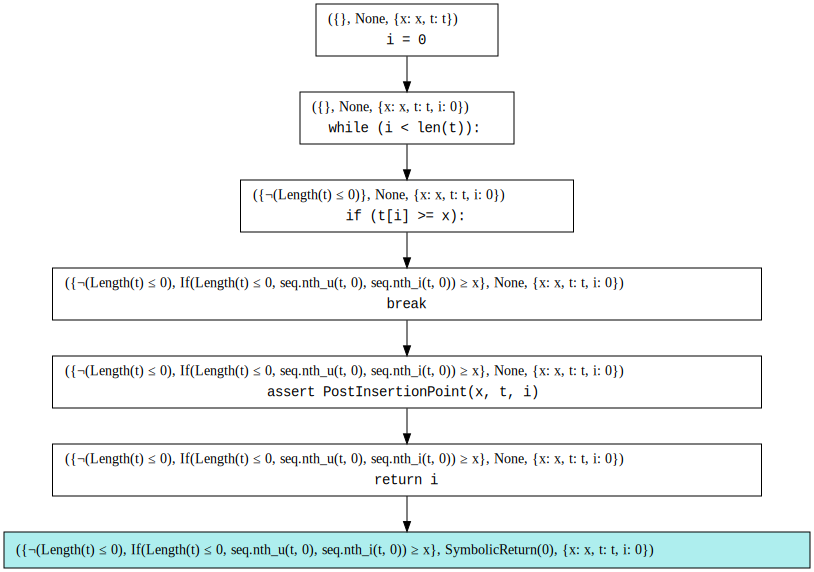

In [13]:
interpreter = ConcolicInterpreter(
    concrete_store=new_store,
    predicates=predicates
)

new_insertion_point_set = interpreter.execute_function_body("insertion_point", insertion_point_program)
display_set(insertion_point_set)

In [14]:
new_final_constraint = z3_and(*get_leaves(new_insertion_point_set)[0][0].environment.path_constraints)
new_final_constraint

And(Length(t) <= 1,
    Not(Length(t) <= 0),
    Not(If(Length(t) <= 0, seq.nth_u(t, 0), seq.nth_i(t, 0)) >=
        x))

In [15]:
s = z3.Solver()
s.add(z3.Not(final_constraint))
s.add(z3.Not(new_final_constraint))
assert s.check() == z3.sat
z3_model = s.model()
z3_model

[t = Empty(Seq(Int)), x = 1 + seq.nth_i(Empty(Seq(Int)), 0)]

```{admonition} TODO
Explain that this is the principle of concolic testing, and we will discuss how to turn this into a verification procedure in Testing chapter. (Note that the returned z3 expr tries to extract an element from an empty sequence).
```